In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
firstRow_se=session.query(Measurement).first()
firstRow_se.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fb70c1027f0>,
 'station': 'USC00519397',
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01',
 'prcp': 0.08}

In [11]:
firstRow_sa=session.query(Station).first()
firstRow_sa.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fb6f882d370>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
latest_date=session.query(Measurement).order_by(Measurement.date.desc()).first()
latest_date.date

'2017-08-23'

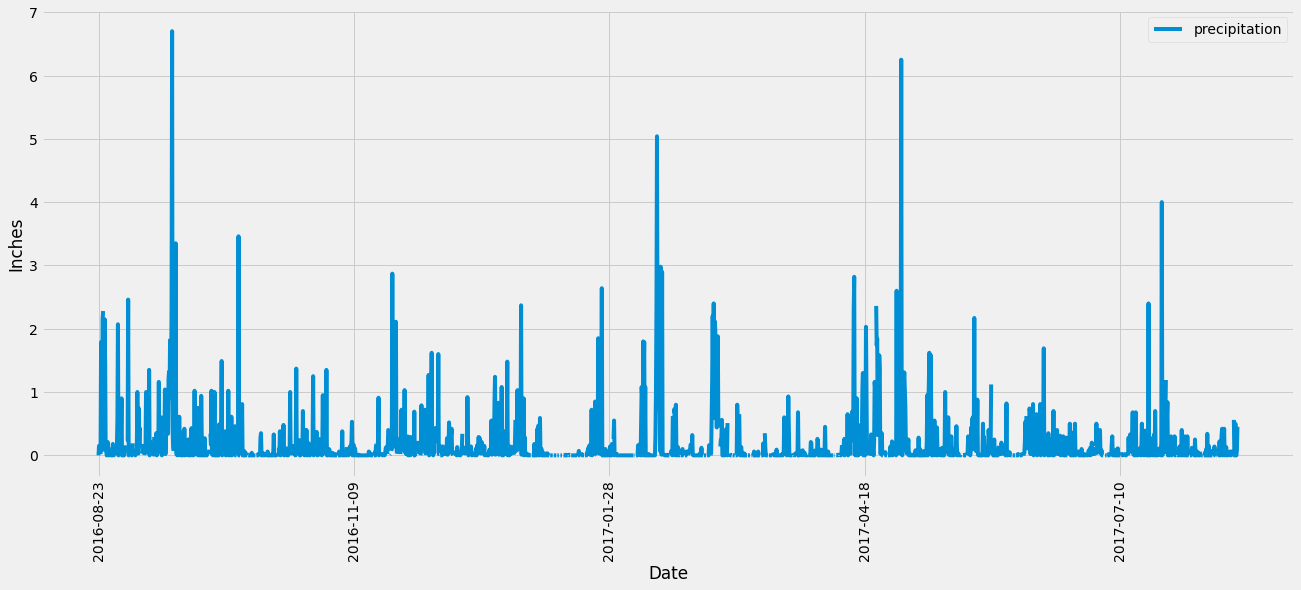

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
import datetime as dt

latest_date = dt.datetime(2017, 8, 23)

# Calculate the date one year from the last date in data set.
year_ago = latest_date - dt.timedelta(days=366)


# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.prcp, 
                        Measurement.date).\
                  filter(Measurement.date > year_ago).order_by('date').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

precipitation = [{"Date": result[1], "precipitation": result[0]} for result in results]

pd.DataFrame(precipitation).set_index('Date').plot(figsize=(20, 8))

plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper right')
plt.xticks(rotation='vertical')

plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitationDF=pd.DataFrame(precipitation)
print (precipitationDF.describe())

       precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
stationcount = session.query(Station).group_by(Station.station).count()
stationcount

9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

stationrows=session.query(Measurement.station,\
                          func.count(Measurement.date)).\
                          group_by(Measurement.station).\
                          order_by(func.count(Measurement.date).desc()).all()
stationrows

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs),
      ]

station_USC00519281=session.query(*sel).filter(Measurement.station =="USC00519281").all()

station_USC00519281



[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [18]:
inspector =inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


Text(0.5, 0, 'Temperature')

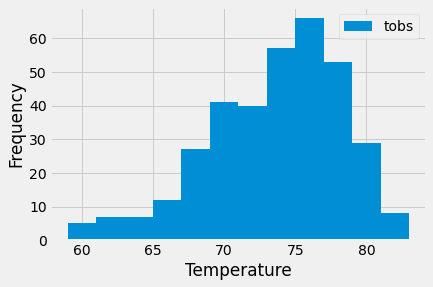

In [29]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results=session.query(Measurement.tobs).\
             filter(Measurement.date > year_ago).\
             filter(Measurement.station =="USC00519281").order_by('tobs').all()

resultsTobsDF=pd.DataFrame(results).round().plot(kind="hist",bins=12)

plt.xlabel('Temperature')


# Close session

In [ ]:
# Close Session
session.close()